### Soccermatics
#### Assignment 2
##### Instructions
* It is summer of 2018. The head scout of your club (the one which group you are in) is looking to sign a player to improve your defence. It doesn't need to be a defender. But it does need to be a player who will strength some aspect of your defensive play.
* She is interested in hearing about a variety of methods for scouting players, so she asks you to create a player radar. You should primarily use the Wyscout data, but can also use Transfermarkt to find the prices of players in summer 2018.
* You should do the following steps:
   1. Implement a number of defensive metrics based on statistical scouting (lesson 3) and valuing actions (lesson 4).
      * Four to six metrics is about right.
      * Create player radars for your own team's players in the position you aim to replace (one of goalkeeper, defender, midfielder, forward).
      * Write a simple non-technical text (at most one page) explaining your radars to the scout and what assumptions it makes.
      * Points will be awarded for the novelty of the metric, the clarity of the explanation and for the technical difficulty of the contribution. (12 points).
   2. Use one of the metrics on your radar to find a single player in another league (not the Premier league), who you would recommend signing.
      * Produce a top-10 list of players in this league for one of the metrics.
      * On this basis, choose a player you would recommend and create a player radar for him. (3 points)
   3. By midnight Friday 30th September send your report (steps 1 and 2) to the other members of your group.
      * On Monday the 3rd of October, you will each present a radar for your player chosen in stage 2 within your group.
      * Your presentation should be no more than 2 minutes.
      * After the presentations, you will have a group discussion comparing your choices.
      * You should write contrasting your own and the other reports and make a final recommendation on this basis (participation in meeting 2 points; final report 3 points)
   4. The final report (deadline Wednesday 5th October) should be 4 pages: roughly 2 pages for part 1, 1 page for part 2, and 1 page for part 3.
   
   
Submit a separate runnable piece of code (preferably in Python) which when put in the directory of the Wyscout data creates the radars. This code must be single file and only uses standard libraries (mplsoccer is fine) and should be runnable when put in the folder with Wyscout data.

I have chosen to scout for Liverpool FC, looking for a midfielder who can help improve defensive outcomes by evaluating performance across the following metrics:
(all posession adjusted per 90):
* Interceptions
* Defensive duel won via anticipation (1801 = successful, 601, 602 = anticipation) Anticipation (602) is used with Defensive Duel and Anticipated (601) is used with Offensive Duel. https://footballdata.wyscout.com/events-manual/
* Passes made as part of a counterattack


TO DO
1. Passing success %
2. xT contribution (including negative)
3. Adjust defensive actions for opposition possession (is this not just the inverse?)
4. Age / market value from Transfermarkt

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

from tqdm import tqdm

from dataclasses import dataclass

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import pathlib
import warnings

from scipy import stats
from mplsoccer import Pitch, PyPizza, FontManager

In [2]:
CURRENT_DATE = dt.datetime(2018, 6, 1) # "Summer 2018"

MINIMUM_90s = 5
TARGET_ROLE = 'Midfielder' # Goalkeeper, Defender, Midfielder, Forward

WYSCOUT_MIN_COORD = 0
WYSCOUT_MAX_COORD = 100

In [3]:
# incomplete but good enough?
# this data uses v2 API
# https://docs.google.com/document/d/11mNbM7kX2xKStQ1UCoBfUgYNxJ2b1Kgqrg_x8wC6JQo/edit
# https://apidocs.wyscout.com/
wyscout_tags = [
    (101, 'goal'),
    (102, 'own_goal'),
    (301, 'assist'),
    (302, 'key_pass'),
    (1901, 'counter_attack'),
    (401, 'left_foot'),
    (402, 'right_foot'),
    (403, 'head/body'),
    (1101, 'direct'),
    (1102, 'indirect'),
    (2001, 'dangerous_ball_lost'),
    (2101, 'blocked'),
    (801, 'high'),
    (802, 'low'),
    (1401, 'interception'),
    (1501, 'clearance'),
    (201, 'opportunity'),
    (1301, 'feint'),
    (1302, 'missed_ball'),
    (501, 'free_space_right'),
    (502, 'free_space_left'),
    (503, 'take_on_left'),
    (504, 'take_on_right'),
    (1601, 'sliding_tackle'),
    (601, 'anticipated'),
    (602, 'anticipation'),
    (1701, 'red_card'),
    (1702, 'yellow_card'),
    (1703, 'second_yellow_card'),
    (1201, 'position_goal_low_center'),
    (1202, 'position_goal_low_right'),
    (1203, 'position_goal_mid_center'),
    (1204, 'position_goal_mid_left'),
    (1205, 'position_goal_low_left'),
    (1206, 'position_goal_mid_right'),
    (1207, 'position_goal_high_center'),
    (1208, 'position_goal_high_left'),
    (1209, 'position_goal_high_right'),
    (1210, 'position_out_low_right'),
    (1211, 'position_out_mid_left'),
    (1212, 'position_out_low_left'),
    (1213, 'position_out_mid_right'),
    (1214, 'position_out_high_center'),
    (1215, 'position_out_high_left'),
    (1216, 'position_out_high_right'),
    (1217, 'position_post_low_right'),
    (1218, 'position_post_mid_left'),
    (1219, 'position_post_low_left'),
    (1220, 'position_post_mid_right'),
    (1221, 'position_post_high_center'),
    (1222, 'position_post_high_left'),
    (1223, 'position_post_high_right'),
    (901, 'through'),
    (1001, 'fairplay'),
    (701, 'lost'),
    (702, 'neutral'),
    (703, 'won'),
    (1801, 'accurate'),
    (1802, 'not_accurate')
]

In [4]:
wyscout_tags_dict = dict(wyscout_tags)

In [5]:
def get_wyscout_data(file_name, sub_directory=None):

    if sub_directory:
        path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', sub_directory, file_name)
    else:
        path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', file_name)

    #open data
    with open(path) as f:
        df = pd.read_json(f, encoding='latin')
    
    return df

In [6]:
df_competitions = get_wyscout_data('competitions.json')
df_teams = get_wyscout_data('teams.json')
df_players = get_wyscout_data('players.json')
df_players['role_name'] = df_players['role'].apply(lambda x: x.get('name'))
df_players['birthDate'] = pd.to_datetime(df_players['birthDate'])

In [7]:
df_players['age'] = (CURRENT_DATE - df_players['birthDate']).astype('timedelta64[D]') / 365.25

In [8]:
league_countries = ['England', 'Spain', 'Italy', 'Germany', 'France'] # ignore internationals i.e. World Cup and EUROs

In [9]:
matches = {}

for country in league_countries:
    file_name = 'matches_' + country + '.json'
    matches[country] = get_wyscout_data(file_name, sub_directory='matches')

df_matches = pd.concat(matches).reset_index()

In [10]:
events = {}

for country in tqdm(league_countries):
    file_name = 'events_' + country + '.json'
    events[country] = get_wyscout_data(file_name, sub_directory='events')

df_events = pd.concat(events).reset_index()

100%|██████████| 5/5 [01:34<00:00, 18.82s/it]


In [11]:
minutes_per_game = {}

for country in league_countries:
    file_name = 'minutes_played_per_game_' + country + '.json'
    minutes_per_game[country] = get_wyscout_data(file_name, sub_directory='minutes_played')

df_minutes_per_game = pd.concat(minutes_per_game).reset_index()

In [12]:
group_by = ['playerId', 'shortName'] # group_by = ['level_0', 'playerId', 'shortName']

df_minutes_season = df_minutes_per_game[group_by + ['minutesPlayed']].groupby(group_by).sum()
df_minutes_season

,,minutesPlayed
playerId,shortName,
33,J. Cillessen,93
36,T. Alderweireld,1238
38,D. Blind,382
45,G. van der Wiel,313
48,J. Vertonghen,3343
...,...,...
545811,Hugo Duro,24
551398,David Alba,63
564512,S. Sanogo,44


In [13]:
team_id_liverpool = df_teams[df_teams['name']=='Liverpool']['wyId'].to_numpy()[0]
df_liverpool_players = df_players[df_players['currentTeamId']==team_id_liverpool]

In [14]:
df_events[['position_start', 'position_end']] = pd.DataFrame(df_events['positions'].to_list())

for coord in ['x', 'y']:
    df_events[coord + '_start'] = df_events['position_start'].apply(lambda x: x.get(coord))
    df_events[coord + '_end'] = df_events['position_end'].apply(lambda x: x.get(coord) if x else None)

df_events

,level_0,level_1,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,position_start,position_end,x_start,x_end,y_start,y_end
0,England,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,"{'y': 49, 'x': 49}","{'y': 78, 'x': 31}",49,31.0,49,78.0
1,England,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,"{'y': 78, 'x': 31}","{'y': 75, 'x': 51}",31,51.0,78,75.0
2,England,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,"{'y': 75, 'x': 51}","{'y': 71, 'x': 35}",51,35.0,75,71.0
3,England,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,"{'y': 71, 'x': 35}","{'y': 95, 'x': 41}",35,41.0,71,95.0
4,England,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,"{'y': 95, 'x': 41}","{'y': 88, 'x': 72}",41,72.0,95,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,France,632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980,"{'y': 65, 'x': 87}","{'y': 100, 'x': 100}",87,100.0,65,100.0
3071391,France,632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978,"{'y': 0, 'x': 0}","{'y': 35, 'x': 13}",0,13.0,0,35.0
3071392,France,632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981,"{'y': 52, 'x': 50}","{'y': 47, 'x': 44}",50,44.0,52,47.0
3071393,France,632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982,"{'y': 47, 'x': 44}","{'y': 8, 'x': 41}",44,41.0,47,8.0


In [15]:
group_by = ['eventId', 'subEventId', 'eventName', 'subEventName']

df_events_grouped = df_events[group_by + ['id']].groupby(group_by).count().sort_values('eventId', ascending=False)
df_events_grouped.columns = ['number_of_events']
df_events_grouped

number_of_events
eventId subEventId eventName               subEventName                             
10      100        Shot                    Shot                                40461
9       91         Save attempt            Save attempt                         6375
        90         Save attempt            Reflexes                            10192
8       83         Pass                    High pass                          123214
        80         Pass                    Cross                               58634
        81         Pass                    Hand pass                           13135
        82         Pass                    Head pass                           91194
        84         Pass                    Launch                              43303
        85         Pass                    Simple pass                       1207448
        86         Pass                    Smart pass                          28428
7       72         Others on the ball      Touch                              165296
        71         Others on the ball      Clearance                           53165
        70         Others on the ball      Acceleration                        24376
6                  Offside                                                      7821
5       51         Interruption            Whistle                               917
        50         Interruption            Ball out of the field              129179
4       40         Goalkeeper leaving line Goalkeeper leaving line              5779
3       36         Free Kick               Throw in                            80305
        34         Free Kick               Goal kick                           29725
        33         Free Kick               Free kick shot                       2038
        32         Free Kick               Free kick cross                      8134
        31         Free Kick               Free Kick                           43544
        30         Free Kick               Corner                              18181
        35         Free Kick               Penalty                               541
2       25         Foul                    Simulation                            108
        27         Foul                    Violent Foul                           74
        26         Foul                    Time lost foul                        205
        24         Foul                    Protest                               561
        23         Foul                    Out of game foul                      473
        22         Foul                    Late card foul                        300
        21         Foul                    Hand foul                            1941
        20         Foul                    Foul                                44293
1       12         Duel                    Ground defending duel              264552
        11         Duel                    Ground attacking duel              265456
        13         Duel                    Ground loose ball duel             143861
        10         Duel                    Air duel                           158186

In [16]:
def filter_by_event_or_sub_event(df=df_events, eventId=None, subEventId=[], x_min=WYSCOUT_MIN_COORD, x_max=WYSCOUT_MAX_COORD, y_min=WYSCOUT_MIN_COORD, y_max=WYSCOUT_MAX_COORD):

    df_filtered = df.copy(deep=True)
    
    if eventId:
        df_filtered = df_filtered[df_filtered['eventId']==eventId]

    if subEventId:
        df_filtered = df_filtered[df_filtered['subEventId'].isin(subEventId)]

    location_filters = (df_filtered['x_start'] >= x_min) & (df_filtered['x_start'] <= x_max) & (df_filtered['y_start'] >= y_min) & (df_filtered['y_start'] <= y_max)
    df_filtered = df_filtered[location_filters]

    return df_filtered

In [17]:
def get_tags_for_event(eventId=None, subEventId=None):

    df_filtered = filter_by_event_or_sub_event(eventId=eventId, subEventId=subEventId)
        
    df_exploded = df_filtered.explode('tags')
    df_exploded['tag_id'] = df_exploded['tags'].apply(lambda x: x.get('id'))

    df_grouped = df_exploded[['tag_id', 'eventName', 'subEventName', 'eventId']].groupby(['eventName', 'subEventName', 'tag_id']).count()
    df_grouped = df_grouped.sort_values('eventId', ascending=False)
    df_grouped.columns = ['number_of_events']

    return df_grouped

In [18]:
get_tags_for_event(eventId=1, subEventId=[12])

number_of_events
eventName subEventName          tag_id                  
Duel      Ground defending duel 1801              133399
                                1802              131153
                                701               130720
                                702                75284
                                703                58111
                                502                30149
                                501                29330
                                504                27143
                                503                22843
                                601                16358
                                1601               12299
                                1901                2886
                                602                  182
                                1702                   1
                                1703                   1

In [19]:
def get_metrics(df=df_events, eventId=None, subEventId=None, x_min=WYSCOUT_MIN_COORD, x_max=WYSCOUT_MAX_COORD, y_min=WYSCOUT_MIN_COORD, y_max=WYSCOUT_MAX_COORD, tags=[]):
    '''
    Takes a Wyscout Event ID and/or Sub Event ID, plus a list of Wyscout event tags
    Returns a dataframe of events where all tags in the list were found
    '''

    df_events_meeting_criteria = filter_by_event_or_sub_event(eventId=eventId, subEventId=subEventId, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

    for tag in tags:
        tag_name = wyscout_tags_dict[tag]
        df_events_meeting_criteria[tag_name] = df_events_meeting_criteria['tags'].apply(lambda x: {'id':tag} in x)
        df_events_meeting_criteria = df_events_meeting_criteria[df_events_meeting_criteria[tag_name]==True]

    return df_events_meeting_criteria

In [20]:
get_metrics(tags=[2101]).groupby(['subEventName']).count()

,level_0,level_1,eventId,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,position_start,position_end,x_start,x_end,y_start,y_end,blocked
subEventName,,,,,,,,,,,,,,,,,,,,
Corner,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
Cross,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677,9677
Free kick cross,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
Free kick shot,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680
Shot,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548


In [21]:
def summarise_events_by_player(df_of_specific_events, plain_english_label=False):
    
    df_grouped = df_of_specific_events[['playerId', 'id']].groupby('playerId').count()
    df_grouped.columns = [plain_english_label]

    return df_grouped

In [22]:
@dataclass
class PlayerMetric:
    '''Class for storing a complete definition of a player metric.'''
    metric_name: str
    eventId: int = None
    subEventId: list = None
    tags: list = None
    ranking_weight: float = 1.0 # for weighting importance in multiple feature ranking
    x_start_min: float = WYSCOUT_MIN_COORD
    x_start_max: float = WYSCOUT_MAX_COORD
    y_start_min: float = WYSCOUT_MIN_COORD
    y_start_max: float = WYSCOUT_MAX_COORD
    bigger_is_better: bool = True # false if something like giving the ball away
    possession_adjustment_perspective: str = 'team' # "team" for on the ball events, "opposition" for defensive metrics e.g. tackles


In [23]:
metrics_definitions = [
    PlayerMetric(metric_name='ground_duels_won_by_anticipation', eventId=1, subEventId=[12], ranking_weight=3,
                 tags=[601, 1801], bigger_is_better=True, possession_adjustment_perspective='opposition'),

    PlayerMetric(metric_name='interceptions', eventId=None, subEventId=None, tags=[1401], ranking_weight=3,
        bigger_is_better=True, possession_adjustment_perspective='opposition'),

    PlayerMetric(metric_name='key_passes', eventId=8, tags=[302, 1801], ranking_weight=1,
        bigger_is_better=True, possession_adjustment_perspective='team'),

#    PlayerMetric(metric_name='passes_as_part_of_counterattack', eventId=8, tags=[1901, 1801],
#        bigger_is_better=True, possession_adjustment_perspective='team'),

    PlayerMetric(metric_name='passes_from_outside_defensive_box', eventId=8, subEventId=[83, 86], tags=[1801], ranking_weight=2,
        x_start_min=16, x_start_max=50, y_start_min=19, y_start_max=81, bigger_is_better=True, possession_adjustment_perspective='team'),
    # PlayerMetric('dangerous_balls_given_away', None, None, [2001], False),

    PlayerMetric(metric_name='fouls_committed', eventId=2, tags=[], ranking_weight=1,
        bigger_is_better=False, possession_adjustment_perspective='opposition'),
]

df_player_aggregates = pd.DataFrame()

for definition in metrics_definitions:
    df_each_event = get_metrics(df=df_events, eventId=definition.eventId,
                                subEventId=definition.subEventId, tags=definition.tags)
    df_player_aggregates = pd.concat([df_player_aggregates, summarise_events_by_player(
        df_each_event, definition.metric_name)], axis=1)


In [24]:
df_player_aggregates

,ground_duels_won_by_anticipation,interceptions,key_passes,passes_from_outside_defensive_box,fouls_committed
playerId,,,,,
0,1106.0,240.0,NaN,2.0,343.0
36,1.0,54.0,2.0,81.0,9.0
38,2.0,21.0,1.0,12.0,5.0
45,1.0,17.0,1.0,7.0,NaN
48,33.0,211.0,3.0,91.0,20.0
...,...,...,...,...,...
448038,NaN,NaN,NaN,NaN,1.0
493415,NaN,NaN,NaN,NaN,1.0
520774,NaN,NaN,NaN,NaN,1.0


In [25]:
df_all_players = df_players[['wyId', 'shortName', 'firstName', 'lastName', 'currentTeamId', 'role_name']]
df_all_players

,wyId,shortName,firstName,lastName,currentTeamId,role_name
0,32777,H. Tekin,Harun,Tekin,4502,Goalkeeper
1,393228,M. Sarr,Malang,Sarr,3775,Defender
2,393230,O. Mandanda,Over,Mandanda,3772,Goalkeeper
3,32793,A. N'Diaye,Alfred John Momar,N'Diaye,683,Midfielder
4,393247,I. Konat\u00e9,Ibrahima,Konat\u00e9,2975,Defender
...,...,...,...,...,...,...
3598,120839,A. Ma\u00e2loul,Ali,Ma\u00e2loul,16041,Defender
3599,114736,C. C\u00e1ceda,Carlos Alberto,C\u00e1ceda Oyaguez,15591,Goalkeeper
3600,114908,M. Araujo,Miguel Gianpierre,Araujo Blanco,12072,Defender
3601,285583,A. Tagnaouti,Ahmed Reda,Tagnaouti,16183,Goalkeeper


In [26]:
df_all_players_with_minutes = df_all_players.merge(df_minutes_season, how='left', left_on='wyId', right_on='playerId')
df_all_players_with_minutes['minutesPlayed'] = df_all_players_with_minutes['minutesPlayed'].fillna(0)
df_all_players_with_minutes['90s'] = df_all_players_with_minutes['minutesPlayed'] / 90
df_all_players_with_minutes = df_all_players_with_minutes[df_all_players_with_minutes['90s']>=MINIMUM_90s]
df_all_players_with_minutes.sort_values('minutesPlayed', ascending=False)

,wyId,shortName,firstName,lastName,currentTeamId,role_name,minutesPlayed,90s
2915,8726,A. Begovi\u0107,Asmir,Begovi\u0107,1659,Goalkeeper,3612.0,40.133333
1540,20635,F. Acerbi,Francesco,Acerbi,3315,Defender,3591.0,39.900000
743,8653,H. Maguire,Harry,Maguire,1631,Defender,3586.0,39.844444
1794,350999,G. Donnarumma,Gianluigi,Donnarumma,3157,Goalkeeper,3583.0,39.811111
801,10131,J. Pickford,Jordan,Pickford,1623,Goalkeeper,3575.0,39.722222
...,...,...,...,...,...,...,...,...
90,99633,I. Lewczuk,Igor,Lewczuk,3772,Defender,457.0,5.077778
413,364870,Adri\u00e1n Di\u00e9guez,Adri\u00e1n,Di\u00e9guez Grande,696,Defender,452.0,5.022222
562,366542,J. Reine-Adelaide,Jeff,Reine-Adelaide,3799,Midfielder,451.0,5.011111
2697,658,S. Armenteros,Kristiano Samuel,Armenteros Nunez Mendoza Jansson,8113,Forward,451.0,5.011111


In [27]:
df_all_players_with_minutes_and_metrics = df_all_players_with_minutes.merge(df_player_aggregates, how='left', left_on='wyId', right_index=True)

for definition in metrics_definitions:
    if definition.bigger_is_better:
        df_all_players_with_minutes_and_metrics[definition.metric_name] = df_all_players_with_minutes_and_metrics[definition.metric_name].fillna(0)

df_all_players_with_minutes_and_metrics

,wyId,shortName,firstName,lastName,currentTeamId,role_name,minutesPlayed,90s,ground_duels_won_by_anticipation,interceptions,key_passes,passes_from_outside_defensive_box,fouls_committed
1,393228,M. Sarr,Malang,Sarr,3775,Defender,1379.0,15.322222,6.0,71.0,1.0,45.0,13.0
4,393247,I. Konat\u00e9,Ibrahima,Konat\u00e9,2975,Defender,1267.0,14.077778,9.0,72.0,1.0,39.0,13.0
6,36,T. Alderweireld,Toby,Alderweireld,1624,Defender,1238.0,13.755556,1.0,54.0,2.0,81.0,9.0
7,48,J. Vertonghen,Jan,Vertonghen,1624,Defender,3343.0,37.144444,33.0,211.0,3.0,91.0,20.0
8,229427,A. Djiku,Alexander,Djiku,3783,Defender,2613.0,29.033333,34.0,170.0,0.0,62.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,292654,M. Diakhaby,Mouctar,Diakhaby,674,Defender,765.0,8.500000,5.0,55.0,0.0,8.0,7.0
3408,325781,J. Lea Siliki,James Edward,Lea Siliki,3774,Midfielder,1820.0,20.222222,4.0,53.0,5.0,35.0,37.0
3409,326946,R. Coly,Racine,Coly,3775,Defender,639.0,7.100000,3.0,42.0,1.0,2.0,17.0
3423,393214,V. Rosier,Valentin,Rosier,3804,Defender,2881.0,32.011111,11.0,193.0,6.0,51.0,63.0


In [28]:
for definition in metrics_definitions:
    column_name_per_90 = definition.metric_name + '_p90'
    df_all_players_with_minutes_and_metrics[column_name_per_90] = df_all_players_with_minutes_and_metrics[definition.metric_name] / df_all_players_with_minutes_and_metrics['90s']

In [29]:
df_all_players_with_minutes_and_metrics

,wyId,shortName,firstName,lastName,currentTeamId,role_name,minutesPlayed,90s,ground_duels_won_by_anticipation,interceptions,key_passes,passes_from_outside_defensive_box,fouls_committed,ground_duels_won_by_anticipation_p90,interceptions_p90,key_passes_p90,passes_from_outside_defensive_box_p90,fouls_committed_p90
1,393228,M. Sarr,Malang,Sarr,3775,Defender,1379.0,15.322222,6.0,71.0,1.0,45.0,13.0,0.391588,4.633793,0.065265,2.936911,0.848441
4,393247,I. Konat\u00e9,Ibrahima,Konat\u00e9,2975,Defender,1267.0,14.077778,9.0,72.0,1.0,39.0,13.0,0.639305,5.114444,0.071034,2.770324,0.923441
6,36,T. Alderweireld,Toby,Alderweireld,1624,Defender,1238.0,13.755556,1.0,54.0,2.0,81.0,9.0,0.072698,3.925687,0.145396,5.888530,0.654281
7,48,J. Vertonghen,Jan,Vertonghen,1624,Defender,3343.0,37.144444,33.0,211.0,3.0,91.0,20.0,0.888424,5.680526,0.080766,2.449895,0.538439
8,229427,A. Djiku,Alexander,Djiku,3783,Defender,2613.0,29.033333,34.0,170.0,0.0,62.0,43.0,1.171068,5.855339,0.000000,2.135476,1.481056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,292654,M. Diakhaby,Mouctar,Diakhaby,674,Defender,765.0,8.500000,5.0,55.0,0.0,8.0,7.0,0.588235,6.470588,0.000000,0.941176,0.823529
3408,325781,J. Lea Siliki,James Edward,Lea Siliki,3774,Midfielder,1820.0,20.222222,4.0,53.0,5.0,35.0,37.0,0.197802,2.620879,0.247253,1.730769,1.829670
3409,326946,R. Coly,Racine,Coly,3775,Defender,639.0,7.100000,3.0,42.0,1.0,2.0,17.0,0.422535,5.915493,0.140845,0.281690,2.394366
3423,393214,V. Rosier,Valentin,Rosier,3804,Defender,2881.0,32.011111,11.0,193.0,6.0,51.0,63.0,0.343631,6.029157,0.187435,1.593197,1.968067


In [30]:
# https://en.wikipedia.org/wiki/Weighted_product_model

# How to pick best across multiple criteria?

In [31]:
# 'get' in the lambda

In [32]:
# calculate possession per player

def build_posession_dataframe():
    possession_dict = {}
    #for every row in the dataframe
    for i, row in tqdm(df_minutes_per_game.iterrows()):
        #take player id, team id and match id, minute in and minute out
        player_id, team_id, match_id = row['playerId'], row['teamId'], row['matchId']
        #create a key in dictionary if player encounterd first time
        if not str(player_id) in possession_dict.keys():
            possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
        seconds_in = row['player_in_min'] * 60
        seconds_out = row['player_out_min'] * 60

        #get the dataframe of events from the game
        match_df = df_events.loc[df_events['matchId'] == match_id].copy()
        #add to 2H the highest value of 1H

        match_df.loc[match_df['matchPeriod'] == '2H', 'eventSec'] = match_df.loc[match_df['matchPeriod'] == '2H', 'eventSec'] + match_df.loc[match_df['matchPeriod'] == '1H']['eventSec'].iloc[-1]
        #take all events from this game and this period
        player_in_match_df = match_df.loc[match_df['eventSec'] > seconds_in].loc[match_df['eventSec'] <= seconds_out]
        #take all passes and won duels as described
        all_passes = player_in_match_df.loc[player_in_match_df['eventName'].isin(['Pass', 'Duel'])]
        #adjusting for no passes in this period (Tuanzebe)
        if len(all_passes) > 0:
            #removing lost air duels
            no_contact = all_passes.loc[all_passes['subEventName'].isin(['Air duel', 'Ground defending duel','Ground loose ball duel'])].loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
            all_passes = all_passes.drop(no_contact.index)
        #take team passes
        team_passes = all_passes.loc[all_passes['teamId'] == team_id]
        #append it {player id: {team passes: sum, all passes : sum}}
        possession_dict[str(player_id)]['team_passes'] += len(team_passes)
        possession_dict[str(player_id)]['all_passes'] += len(all_passes)

    #calculate possession for each player
    percentage_dict = {key: value['team_passes']/value['all_passes'] if value['all_passes'] > 0 else 0 for key, value in possession_dict.items()}
    #create a dataframe
    percentage_df = pd.DataFrame(percentage_dict.items(), columns = ['playerId', 'possession'])
    percentage_df['playerId'] = percentage_df['playerId'].astype(int)

    percentage_df.to_csv('percentage_possession.csv')

    return percentage_df

In [33]:
# retrieve possession per player if already exists on disk, else build it
try:
    df_possession_per_player = pd.read_csv('percentage_possession.csv', index_col=0)
except FileNotFoundError:
    df_possession_per_player = build_posession_dataframe()

In [34]:
df_possession_per_player

,playerId,possession
0,9206,0.446999
1,9127,0.439018
2,93,0.438288
3,9179,0.471322
4,10108,0.433335
...,...,...
2565,421809,0.608048
2566,37734,0.597884
2567,25519,0.409378
2568,294697,0.648485


In [35]:
df_all_players_with_minutes_and_metrics_and_possession = df_all_players_with_minutes_and_metrics.merge(df_possession_per_player, how='left', left_on='wyId', right_on='playerId')

In [36]:
for definition in metrics_definitions:
    column_name_possession_adjusted_p90 = definition.metric_name + '_p90_padj'
    df_all_players_with_minutes_and_metrics_and_possession[column_name_possession_adjusted_p90] = df_all_players_with_minutes_and_metrics_and_possession[definition.metric_name + '_p90'] / df_all_players_with_minutes_and_metrics_and_possession['possession']


In [37]:
def calculate_percentiles(position=None, df=df_all_players_with_minutes_and_metrics_and_possession, calculate_overall_rank='product'):    
    if position:
        df = df[df['role_name']==position].copy(deep=True)

    column_names_weighted = []
    for definition in metrics_definitions:
        column_name_p90_padj_rank = definition.metric_name + '_p90_padj_rank'
        column_name_weighted_rank = column_name_p90_padj_rank + '_weighted'
        column_names_weighted.append(column_name_weighted_rank)
        df[column_name_p90_padj_rank] = df[definition.metric_name + '_p90_padj'].rank(pct=True, ascending=definition.bigger_is_better)
        df[column_name_p90_padj_rank + '_weighted'] = df[column_name_p90_padj_rank] * definition.ranking_weight

    if calculate_overall_rank == 'product':
        df['overall_rank'] = df[column_names_weighted].prod(axis=1)
    elif calculate_overall_rank == 'sum':
        df['overall_rank'] = df[column_names_weighted].sum(axis=1)

    return df

In [38]:
calculate_percentiles(position='Midfielder', calculate_overall_rank='sum').sort_values('overall_rank', ascending=False).head(30)

,wyId,shortName,firstName,lastName,currentTeamId,role_name,minutesPlayed,90s,ground_duels_won_by_anticipation,interceptions,...,ground_duels_won_by_anticipation_p90_padj_rank_weighted,interceptions_p90_padj_rank,interceptions_p90_padj_rank_weighted,key_passes_p90_padj_rank,key_passes_p90_padj_rank_weighted,passes_from_outside_defensive_box_p90_padj_rank,passes_from_outside_defensive_box_p90_padj_rank_weighted,fouls_committed_p90_padj_rank,fouls_committed_p90_padj_rank_weighted,overall_rank
1752,25798,E. Capoue,Etienne,Capoue,1644,Midfielder,1619.0,17.988889,9.0,115.0,...,2.826516,0.925247,2.775740,0.503526,0.503526,0.829337,1.658674,0.644570,0.644570,8.409027
246,69400,M. Badelj,Milan,Badelj,3162,Midfielder,2445.0,27.166667,14.0,195.0,...,2.796897,0.942172,2.826516,0.616361,0.616361,0.912553,1.825106,0.289140,0.289140,8.354020
826,15777,D. Baier,Daniel,Baier,2481,Midfielder,2613.0,29.033333,12.0,172.0,...,2.729196,0.913963,2.741890,0.496474,0.496474,0.994358,1.988717,0.325811,0.325811,8.282087
1791,8925,A. Westwood,Ashley,Westwood,1646,Midfielder,1169.0,12.988889,4.0,72.0,...,2.433004,0.887165,2.661495,0.578279,0.578279,0.966150,1.932299,0.667137,0.667137,8.272214
1906,339789,Mikel Merino,Mikel,Merino Zaz\u00f3n,687,Midfielder,1419.0,15.766667,14.0,105.0,...,2.987306,0.984485,2.953456,0.637518,0.637518,0.775740,1.551481,0.132581,0.132581,8.262341
195,3566,Camacho,Ignacio,Camacho Barnola,2451,Midfielder,991.0,11.011111,12.0,94.0,...,2.995769,0.997179,2.991537,0.049365,0.049365,0.808181,1.616361,0.530324,0.530324,8.183357
1422,25995,B. Stambouli,Benjamin,Stambouli,2449,Midfielder,2283.0,25.366667,27.0,155.0,...,2.991537,0.915374,2.746121,0.197461,0.197461,0.984485,1.968970,0.256700,0.256700,8.160790
1637,8370,C. Brunt,Chris,Brunt,1627,Midfielder,2011.0,22.344444,5.0,109.0,...,2.052186,0.833568,2.500705,0.822285,0.822285,0.961918,1.923836,0.832158,0.832158,8.131171
807,15455,J. Geis,Johannes,Geis,680,Midfielder,717.0,7.966667,4.0,53.0,...,2.767278,0.906911,2.720733,0.049365,0.049365,0.946403,1.892807,0.692525,0.692525,8.122708
1226,415809,F. Depaoli,Fabio,Depaoli,3165,Midfielder,1237.0,13.744444,5.0,89.0,...,2.784203,0.994358,2.983075,0.868829,0.868829,0.698166,1.396333,0.087447,0.087447,8.119887


In [39]:
df_events['next_event_same_game'] = np.where(df_events['matchId'].shift(-1, fill_value=0) == df_events['matchId'], True, False)

df_events['next_event'] = np.where(df_events['next_event_same_game'] == True, df_events['subEventName'].shift(-1, fill_value=0), np.nan)

df_events['kicked_out'] = np.where(df_events['next_event']=='Ball out of the field', True, False)

In [40]:
movement_sub_events = ['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross']

df_movement_events = df_events[(df_events['subEventName'].isin(movement_sub_events)) & (df_events['kicked_out']==False)]

df_shots = filter_by_event_or_sub_event(df=df_events, eventId=10)

df_goals = get_metrics(df=df_shots, eventId=10, tags=[101])

In [41]:
pitch = Pitch(line_color='black', pitch_type='wyscout', line_zorder = 2) # pitch_length=105, pitch_width=68, 

movement_binned = pitch.bin_statistic(df_movement_events['x_start'], df_movement_events['y_start'], statistic='count', bins=(16, 12), normalize=False)
shots_binned = pitch.bin_statistic(df_shots['x_start'], df_shots['y_start'], statistic='count', bins=(16, 12), normalize=False)
goals_binned = pitch.bin_statistic(df_goals['x_start'], df_goals['y_start'], statistic='count', bins=(16, 12), normalize=False)


move_count = movement_binned["statistic"]
shot_count = shots_binned["statistic"]
goal_count = goals_binned["statistic"]

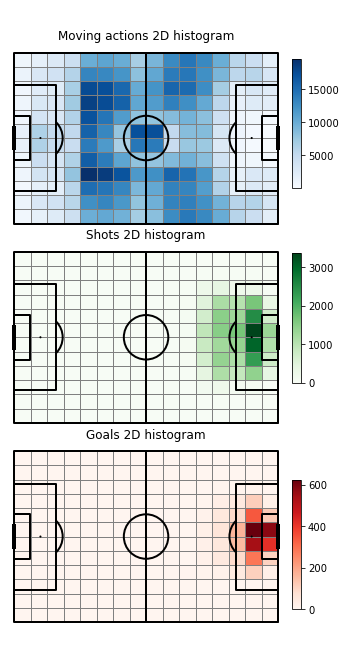

In [42]:
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, nrows=3,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pcm  = pitch.heatmap(movement_binned, cmap='Blues', edgecolor='grey', ax=ax['pitch'][0])
ax_cbar = fig.add_axes((1, 0.72, 0.03, 0.2))
cbar = fig.colorbar(pcm, cax=ax_cbar)
ax['pitch'][0].set_title('Moving actions 2D histogram')


pcm  = pitch.heatmap(shots_binned, cmap='Greens', edgecolor='grey', ax=ax['pitch'][1])
ax_cbar = fig.add_axes((1, 0.42, 0.03, 0.2))
cbar = fig.colorbar(pcm, cax=ax_cbar)
ax['pitch'][1].set_title('Shots 2D histogram')

pcm  = pitch.heatmap(goals_binned, cmap='Reds', edgecolor='grey', ax=ax['pitch'][2])
ax_cbar = fig.add_axes((1, 0.07, 0.03, 0.2))
cbar = fig.colorbar(pcm, cax=ax_cbar)
ax['pitch'][2].set_title('Goals 2D histogram');


In [43]:
move_probability = move_count/(move_count+shot_count)
